In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Polygon
from rasterio.crs import CRS
import requests
import rasterio
from rasterio.plot import show

from tile_mate.tile_model import TILE_SCHEMA
from tile_mate.stitcher import DATA_DIR
from dem_stitcher.geojson_io import to_geojson_gzip

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_63212/3945416830.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
resp = requests.get('https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020.txt')
resp.raise_for_status()

In [3]:
urls = resp.text.split('\n')
urls = list(filter(lambda url: url, urls)) # to ensure nonempty
urls[:10]

['https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_000E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_010E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_020E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_030E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_040E.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_040W.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_050W.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_060W.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_070W.tif',
 'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2020/00N_080W.tif']

In [4]:
with rasterio.open(urls[0]) as ds:
    # X = ds.read(1)
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, 0.0,
       0.0, -0.00025, 0.0), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [5]:
# show(X, cmap='tab20c', transform=p['transform'])

In [6]:
def get_tile_id(url: str) -> str:
    return url.split('/')[-1].replace('.tif', '')
    
def generate_geo(url: str) -> Polygon:
    tile_id = get_tile_id(url)
    lat_str, lon_str = tile_id.split('_')
    
    lon_sgn = -1 if lon_str[-1] == 'W' else 1
    lat_sgn = -1 if lat_str[-1] == 'S' else 1
    
    lon = lon_sgn * int(lon_str[:-1])
    lat = lat_sgn * int(lat_str[:-1])
    return box(lon, lat - 10, lon + 10, lat)



In [22]:
urls[0][:76] + '2000' + urls[0][80:]

'https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/2000/00N_000E.tif'

In [8]:
geometry = [generate_geo(url) for url in urls]
tile_id = [get_tile_id(url) for url in urls]

In [9]:
df_lcluc_2020 = gpd.GeoDataFrame({'tile_id': tile_id,
                                  'url': urls},
                                 geometry=geometry,
                                 crs=CRS.from_epsg(4326))
df_lcluc_2020.head(10)

,tile_id,url,geometry
0,00N_000E,https://storage.googleapis.com/earthenginepart...,"POLYGON ((10.00000 -10.00000, 10.00000 0.00000..."
1,00N_010E,https://storage.googleapis.com/earthenginepart...,"POLYGON ((20.00000 -10.00000, 20.00000 0.00000..."
2,00N_020E,https://storage.googleapis.com/earthenginepart...,"POLYGON ((30.00000 -10.00000, 30.00000 0.00000..."
3,00N_030E,https://storage.googleapis.com/earthenginepart...,"POLYGON ((40.00000 -10.00000, 40.00000 0.00000..."
4,00N_040E,https://storage.googleapis.com/earthenginepart...,"POLYGON ((50.00000 -10.00000, 50.00000 0.00000..."
5,00N_040W,https://storage.googleapis.com/earthenginepart...,"POLYGON ((-30.00000 -10.00000, -30.00000 0.000..."
6,00N_050W,https://storage.googleapis.com/earthenginepart...,"POLYGON ((-40.00000 -10.00000, -40.00000 0.000..."
7,00N_060W,https://storage.googleapis.com/earthenginepart...,"POLYGON ((-50.00000 -10.00000, -50.00000 0.000..."
8,00N_070W,https://storage.googleapis.com/earthenginepart...,"POLYGON ((-60.00000 -10.00000, -60.00000 0.000..."
9,00N_080W,https://storage.googleapis.com/earthenginepart...,"POLYGON ((-70.00000 -10.00000, -70.00000 0.000..."


<Axes: >

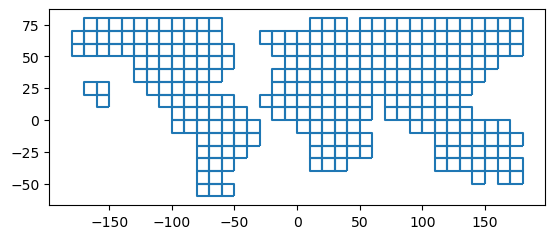

In [10]:
df_lcluc_2020.exterior.plot()

In [11]:
df_lcluc_2020 = TILE_SCHEMA.validate(df_lcluc_2020)

In [12]:
to_geojson_gzip(df_lcluc_2020, str(DATA_DIR / 'glad_landcover_2020.geojson.zip'))

'/Users/cmarshak/bekaert-team/tile-mate/src/tile_mate/data/glad_landcover_2020.geojson.zip'